## Lecture-01

**linear_regression-mnist**
linear_regression으로 MNIST dataset Acc test

### load_data

train=50000,val=10000,test=10000

In [37]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import torch.backends.cudnn as cudnn

batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_dataset =  datasets.MNIST('./data'
                               , train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

50000 10000 10000


### linear_model_define

In [38]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear1_1 = nn.Linear(in_features=784, out_features=784, bias=True)
        self.linear1_2 = nn.Linear(in_features=784, out_features=414, bias=True)
        self.linear1_3 = nn.Linear(in_features=414, out_features=10, bias=True)

        self.sigmoid = nn.LogSigmoid()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.linear1_1(x)
        x = self.sigmoid(x)
        x = self.linear1_2(x)
        x = self.sigmoid(x)
        x = self.linear1_3(x)
        x = self.sigmoid(x)
        return x

### loss_function_define

In [33]:
cls_loss = nn.CrossEntropyLoss()

### train/val/test

In [34]:
# ====== Construct Model ====== #
model = LinearModel().cuda()
model = torch.nn.DataParallel(model)
cudnn.benchmark = True
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.001777    
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 40
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train()
    optimizer.zero_grad() 
    
    for input_X, true_y in train_loader:
        input_X, true_y = input_X.cuda(), true_y.cuda()
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    optimizer.zero_grad()
    
    for input_X, true_y in val_loader:
        input_X, true_y = input_X.cuda(), true_y.cuda()
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    list_val_loss.append(val_loss)

    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    optimizer.zero_grad()

    for input_X, true_y in test_loader:
        input_X, true_y = input_X.cuda(), true_y.cuda()
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
        correct += pred_y.eq(true_y).sum()
        
    acc = correct.item() / len(test_loader.dataset)
    list_acc.append(acc)
    list_acc_epoch.append(i)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Number of 944580 parameters
Epoch: 0, Train Loss: 1.0896940382240374, Val Loss: 0.31594857422611383, Test Acc: 91.05%
Epoch: 1, Train Loss: 0.2359171010877775, Val Loss: 0.18154765175113194, Test Acc: 94.46%
Epoch: 2, Train Loss: 0.1431224825827743, Val Loss: 0.1418394268596474, Test Acc: 95.74000000000001%
Epoch: 3, Train Loss: 0.10897869329966242, Val Loss: 0.14256576349652267, Test Acc: 95.67999999999999%
Epoch: 4, Train Loss: 0.09063319894282715, Val Loss: 0.11947618047647839, Test Acc: 96.67%
Epoch: 5, Train Loss: 0.07940603593064238, Val Loss: 0.11345583051914655, Test Acc: 96.41999999999999%
Epoch: 6, Train Loss: 0.06471807377703508, Val Loss: 0.09685320667686718, Test Acc: 97.18%
Epoch: 7, Train Loss: 0.05279649542692258, Val Loss: 0.09194198613868484, Test Acc: 97.31%
Epoch: 8, Train Loss: 0.04107552966641267, Val Loss: 0.08664314101061112, Test Acc: 97.36%
Epoch: 9, Train Loss: 0.03445873119513435, Val Loss: 0.07882298058771257, Test Acc: 97.36%
Epoch: 10, Train Loss: 0.02791

### Interpret the graph.                                                  #

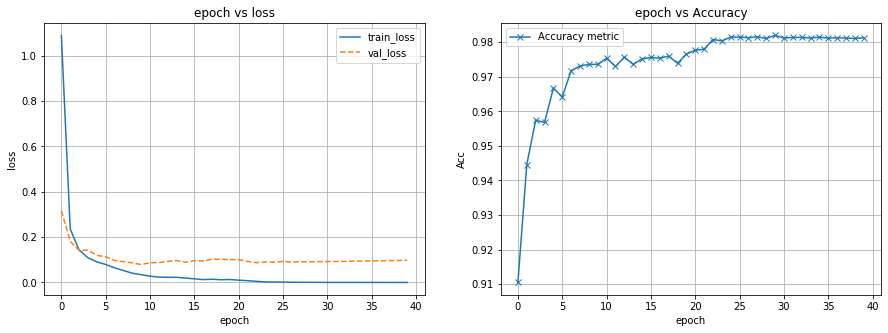

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()